# 1. Install Dependencies and Setup

In [139]:
!pip install tensorflow opencv-python matplotlib

In [140]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites    

In [141]:
import tensorflow as tf
import os

In [142]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [143]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [256]:
import cv2
import imghdr

In [257]:
data_dir = 'data' 

In [258]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [259]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [260]:
import numpy as np
from matplotlib import pyplot as plt

In [261]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 240 files belonging to 10 classes.


In [262]:
data_iterator = data.as_numpy_iterator()

In [263]:
batch = data_iterator.next()

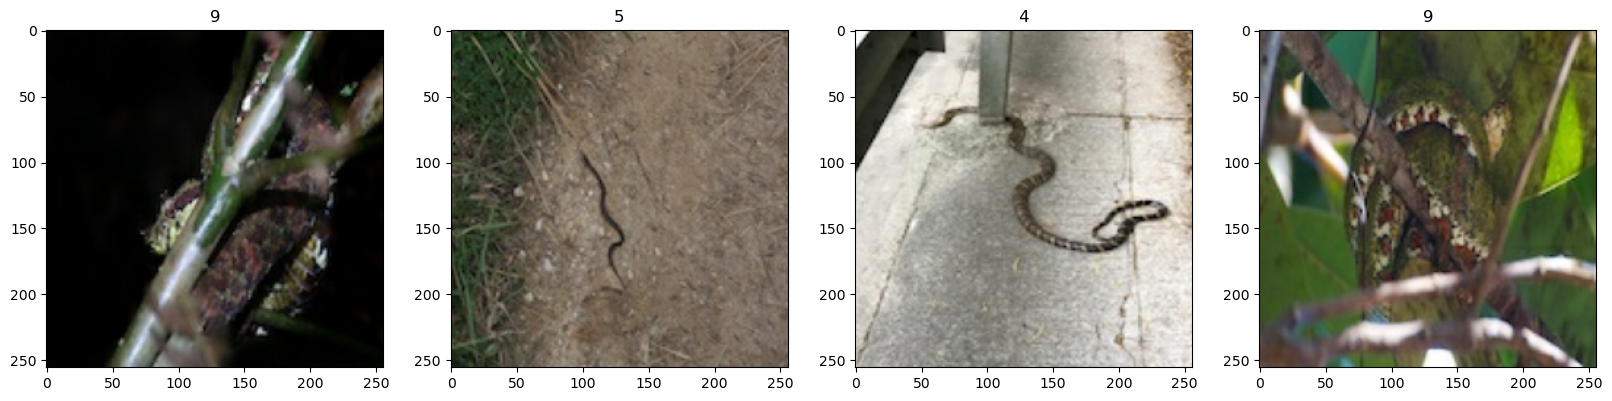

In [264]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [265]:
data = data.map(lambda x,y: (x/255, y))

In [266]:
data.as_numpy_iterator().next()

(array([[[[0.20392157, 0.3019608 , 0.07450981],
          [0.20837928, 0.3049326 , 0.07748162],
          [0.21527267, 0.30952817, 0.08207721],
          ...,
          [0.23026961, 0.27719057, 0.09721201],
          [0.21188726, 0.2565104 , 0.08342525],
          [0.2       , 0.24313726, 0.07450981]],
 
         [[0.1905484 , 0.2811581 , 0.06113664],
          [0.19613217, 0.286382  , 0.06467147],
          [0.20476684, 0.29446015, 0.07013771],
          ...,
          [0.21848683, 0.26694593, 0.08691514],
          [0.20184578, 0.24887773, 0.07486967],
          [0.19108456, 0.23719363, 0.06708027]],
 
         [[0.16986826, 0.24898897, 0.0404565 ],
          [0.17719331, 0.25769547, 0.04486198],
          [0.18852073, 0.27115908, 0.05167458],
          ...,
          [0.20026605, 0.25110373, 0.07099214],
          [0.18631771, 0.23707461, 0.06163941],
          [0.1772978 , 0.22800244, 0.0555913 ]],
 
         ...,
 
         [[0.49246323, 0.59091604, 0.36305147],
          [0.45112

# 5. Split Data

In [267]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [270]:
#print(len(data))
train_size

5

In [271]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [272]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [273]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [274]:
model = Sequential()

In [275]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [276]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [277]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 30, 30, 16)      

# 7. Train

In [278]:
logdir='logs'

In [279]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [280]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 2s 291ms/step - loss: -100.4590 - accuracy: 0.1187 - val_loss: -339.8094 - val_accuracy: 0.1562
Epoch 2/20
5/5 [==============================] - 1s 234ms/step - loss: -999.8583 - accuracy: 0.1250 - val_loss: -2521.4060 - val_accuracy: 0.0625
Epoch 3/20
5/5 [==============================] - 1s 241ms/step - loss: -4942.3638 - accuracy: 0.1125 - val_loss: -9777.4277 - val_accuracy: 0.0469
Epoch 4/20
5/5 [==============================] - 1s 234ms/step - loss: -16947.6875 - accuracy: 0.1063 - val_loss: -25813.4648 - val_accuracy: 0.1094
Epoch 5/20
5/5 [==============================] - 1s 234ms/step - loss: -44828.0117 - accuracy: 0.1063 - val_loss: -87398.0234 - val_accuracy: 0.0781
Epoch 6/20
5/5 [==============================] - 1s 272ms/step - loss: -133858.7031 - accuracy: 0.0875 - val_loss: -225316.8125 - val_accuracy: 0.1094
Epoch 7/20
5/5 [==============================] - 1s 245ms/step - loss: -323622.1562 - accuracy: 0.1125 - v

# 8. Plot Performance

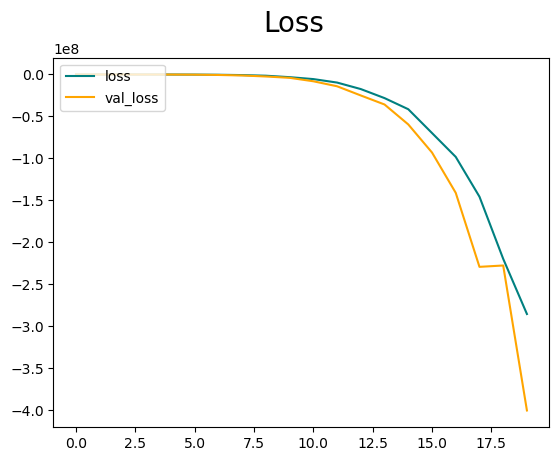

In [281]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

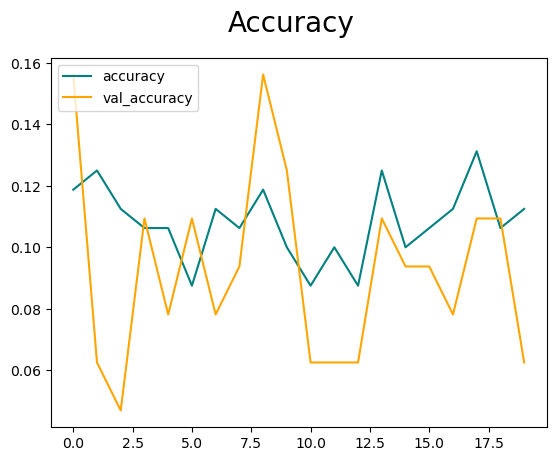

In [282]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

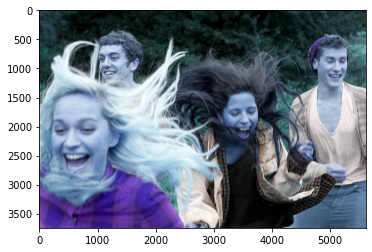

In [39]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

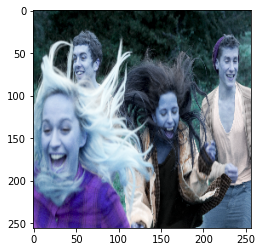

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [42]:
yhat

array([[0.01972741]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)